### Setup

In [98]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
from matplotlib import style
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format
style.use("seaborn-notebook")

### Load dataset

In [99]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

### Randomize data to avoid pathological ordering effects

In [100]:
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0  # Divide median_house_value by 1000 to simplify.
california_housing_dataframe

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
12822     -121.8      37.3                17.0       2277.0           428.0   
10087     -119.8      36.9                17.0       2340.0           370.0   
1574      -117.2      32.9                 5.0       3511.0          1008.0   
1061      -117.1      33.0                 9.0       1531.0           242.0   
11977     -121.4      38.4                10.0       3425.0           629.0   
...          ...       ...                 ...          ...             ...   
5316      -118.1      33.8                44.0       1633.0           536.0   
16442     -122.6      38.1                27.0      10839.0          1637.0   
7843      -118.4      33.9                24.0       2386.0           582.0   
10661     -120.5      38.1                10.0       1566.0           325.0   
5321      -118.2      34.7                36.0       1338.0           250.0   

       population  households  median_income  median_house_value  
12822      1887.0       422.0            5.7               217.0  
10087      1174.0       396.0            4.2                94.4  
1574       1599.0       918.0            3.9               176.6  
1061        850.0       240.0            6.1               263.6  
11977      1538.0       587.0            4.5               138.7  
...           ...         ...            ...                 ...  
5316        741.0       513.0            3.4               408.3  
16442      4406.0      1623.0            5.6               285.6  
7843       1152.0       568.0            4.9               400.7  
10661       785.0       291.0            2.5               116.1  
5321        709.0       250.0            3.6               101.4  

[17000 rows x 9 columns]

### Examine data

In [101]:
california_housing_dataframe.describe()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
count    17000.0   17000.0             17000.0      17000.0         17000.0   
mean      -119.6      35.6                28.6       2643.7           539.4   
std          2.0       2.1                12.6       2179.9           421.5   
min       -124.3      32.5                 1.0          2.0             1.0   
25%       -121.8      33.9                18.0       1462.0           297.0   
50%       -118.5      34.2                29.0       2127.0           434.0   
75%       -118.0      37.7                37.0       3151.2           648.2   
max       -114.3      42.0                52.0      37937.0          6445.0   

       population  households  median_income  median_house_value  
count     17000.0     17000.0        17000.0             17000.0  
mean       1429.6       501.2            3.9               207.3  
std        1147.9       384.5            1.9               116.0  
min           3.0         1.0            0.5                15.0  
25%         790.0       282.0            2.6               119.4  
50%        1167.0       409.0            3.5               180.4  
75%        1721.0       605.2            4.8               265.0  
max       35682.0      6082.0           15.0               500.0

### Define Features and Configure feature columns

In [102]:
# Define input features: total_rooms.
my_features = california_housing_dataframe[["total_rooms"]]

# Configure a numeric feature column for total_rooms.
feature_columns =[tf.feature_column.numeric_column("total_rooms")]

### Define Labels (Targets)

In [103]:
# Define the label.
targets = california_housing_dataframe["median_house_value"]

### Configure LinearRegressor

In [104]:
# Use gradient descent as the optimizer for training model.
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.00002)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning_rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns = feature_columns,
    optimizer = my_optimizer
)

### Define the Input Function

In [105]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into dict of np arrays.
    features = {key: np.array(value) for key, value in dict(features).items()}
    
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
        ds.shuffle(buffer_size=10000)
    
    # Return the next batch of the data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

### Train the Model

In [106]:
_ = linear_regressor.train(
    input_fn = lambda: my_input_fn(my_features, targets),
    steps = 300
)

### Evaluate the Model

In [107]:
# Create an input function for predictions.
# Since we're making just one prediciton for each example, we don't
# need to repeat or shuffle the data here.
prediction_input_fn = lambda: my_input_fn(my_features, targets, num_epochs=1, shuffle=False)

# Call predict() on the linear_regressor to make predictions.
predictions = linear_regressor.predict(input_fn=prediction_input_fn)

# Format predictions as NumPy array, so we can calculate error metrics.
predictions = np.array([item['predictions'][0] for item in predictions])

# Print Mean Squared Error and Root Mean Squared Error.
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean Squared Error (on trainig data): %0.3f" % mean_squared_error)
print("Root Squared Error (on trainig data): %0.3f" % root_mean_squared_error)

Mean Squared Error (on trainig data): 32786.874
Root Squared Error (on trainig data): 181.071


### RMSE min and max of Targets

In [108]:
min_house_value = california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_differece = max_house_value - min_house_value

print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Differece between Min. and Max.: %0.3f" % min_max_differece)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Differece between Min. and Max.: 485.002
Root Mean Squared Error: 181.071


### Calibration

In [109]:
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

predictions  targets
count      17000.0  17000.0
mean          75.6    207.3
std           62.3    116.0
min            0.1     15.0
25%           41.8    119.4
50%           60.8    180.4
75%           90.1    265.0
max         1085.0    500.0

### Uniform Random Sample

In [110]:
sample = california_housing_dataframe.sample(n=300)

### Plot

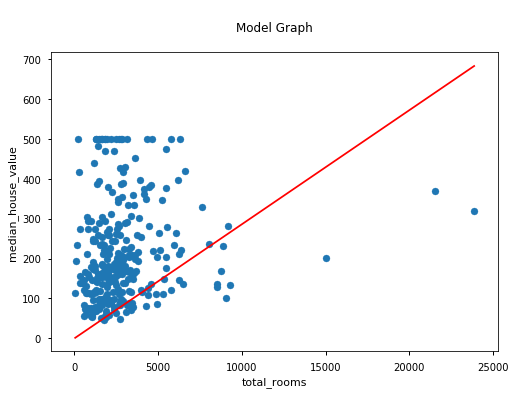

In [111]:
# Get the min and max total_rooms values.
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

# Retrieve the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted median_house_values for the  min and max total_rooms values.
y_0 = weight * x_0 + bias
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# Label the graph axes.
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")
plt.title("\nModel Graph\n")

# Plot a scatter plot from our data sample.
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# Display graph.
plt.show()